In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
def preprocess(dataset):
    df = dataset.replace({'?': None}).dropna()
    return df[['Age', 'Shape', 'Margin', 'Density']], df['Severity']

def preprocess_impute(dataset):
    df = dataset.replace({'?': None})
    df = df.fillna(df.mean())
    return df

## Testing

In [182]:
dpath = "../data/part1_data"
X_train, y_train = preprocess(pd.read_csv(f"{dpath}/train.csv"))
X_val, y_val = preprocess(pd.read_csv(f"{dpath}/val.csv"))
X_test, y_test = preprocess(pd.read_csv(f"{dpath}/test.csv"))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 535
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BI-RADS assessment  455 non-null    object
 1   Age                 455 non-null    object
 2   Shape               455 non-null    object
 3   Margin              455 non-null    object
 4   Density             455 non-null    object
 5   Severity            455 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 24.9+ KB


In [183]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

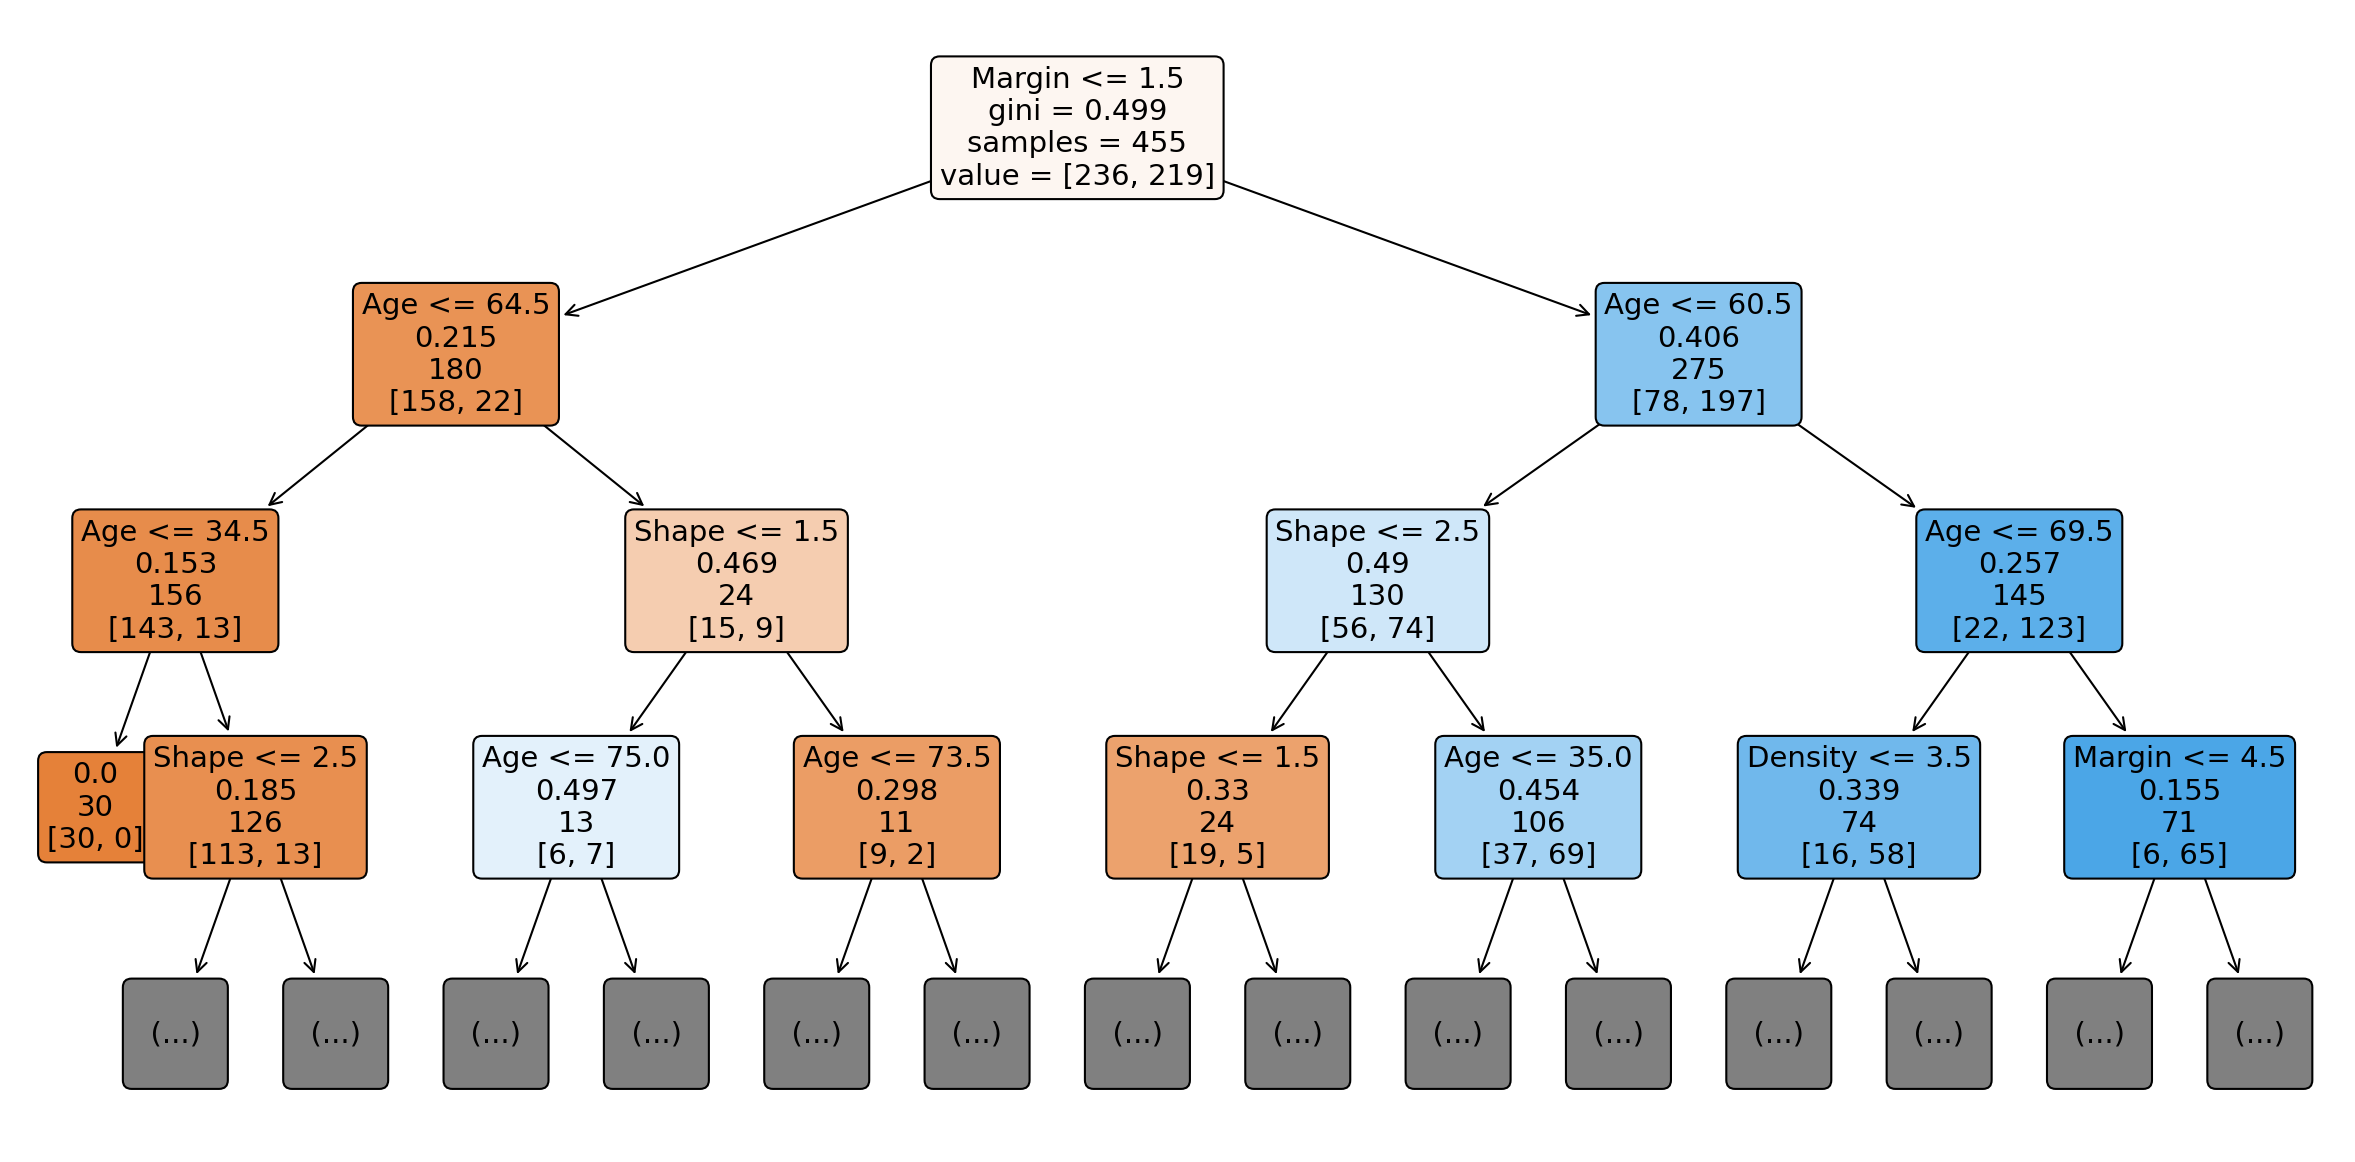

In [184]:
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
ret = tree.plot_tree(clf, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True, max_depth=3)
plt.savefig('tree.pdf', bbox_inches='tight')

In [143]:
from sklearn.metrics import accuracy_score
train_acc = clf.score(X_train, y_train)
val_acc   = clf.score(X_val, y_val)
test_acc  = clf.score(X_test, y_test)
                           
print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9253
Validation accuracy: 0.7603
Test accuracy: 0.6877


In [144]:
from sklearn.model_selection import GridSearchCV
grid_searcher = GridSearchCV(clf, {'max_depth': range(4,11,2), 'min_samples_split': range(2,6), 'min_samples_leaf': range(1,6)})
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(4, 11, 2),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 6)})

In [145]:
grid_searcher.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [146]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, grid_searcher.predict(X_train))
val_acc   = accuracy_score(y_val,   grid_searcher.predict(X_val))
test_acc  = accuracy_score(y_test,  grid_searcher.predict(X_test))
                           
print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.8198
Validation accuracy: 0.8760
Test accuracy: 0.7510


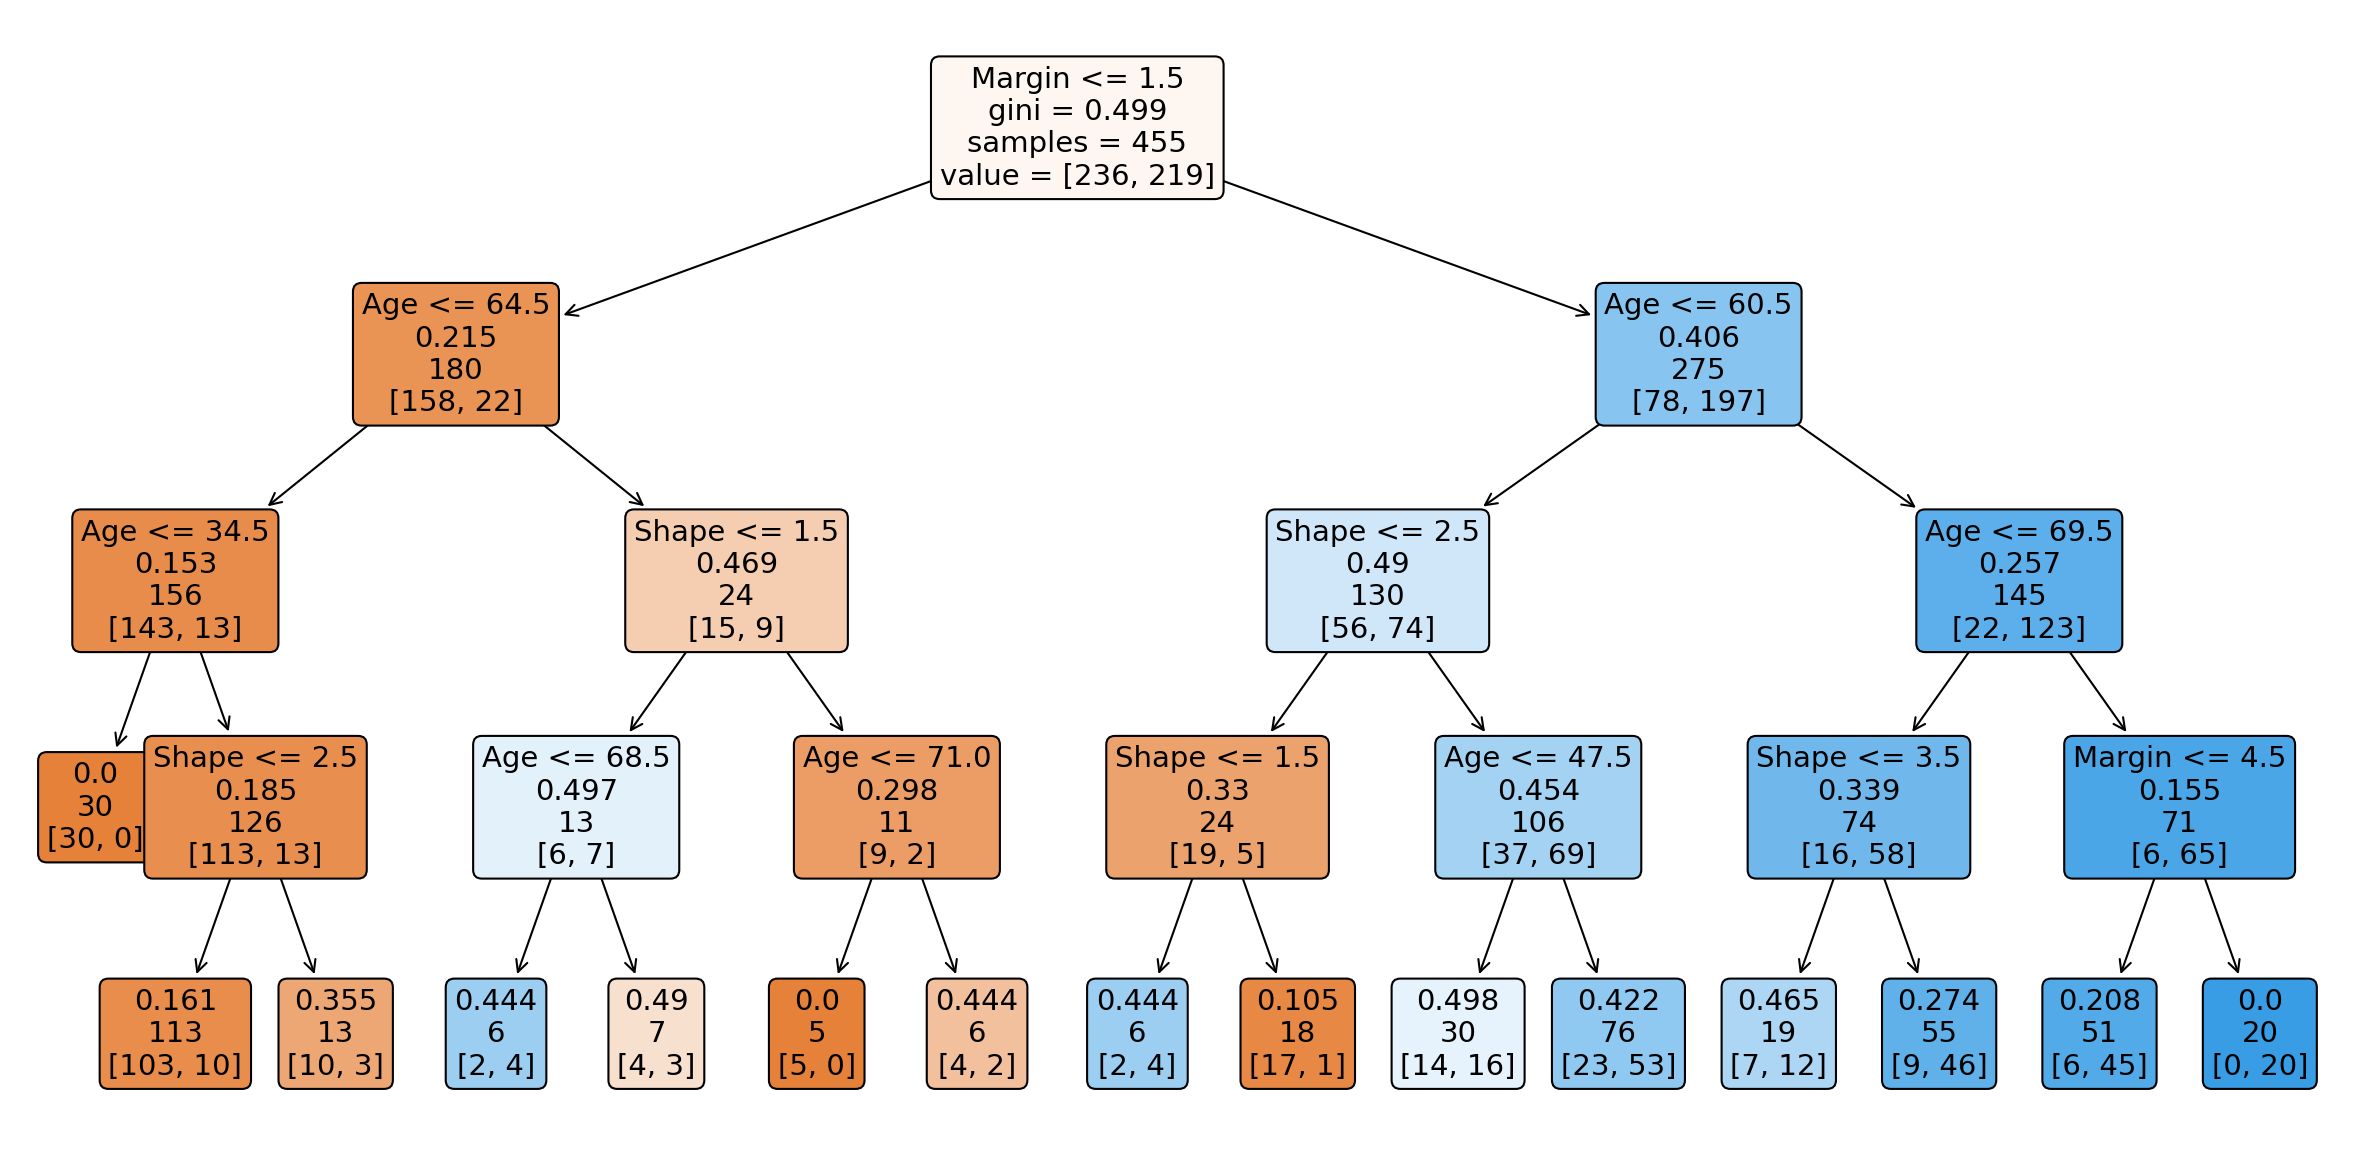

In [161]:
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
ret = tree.plot_tree(grid_searcher.best_estimator_, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True) 
plt.savefig('tree_optimal.pdf', bbox_inches='tight')

In [148]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

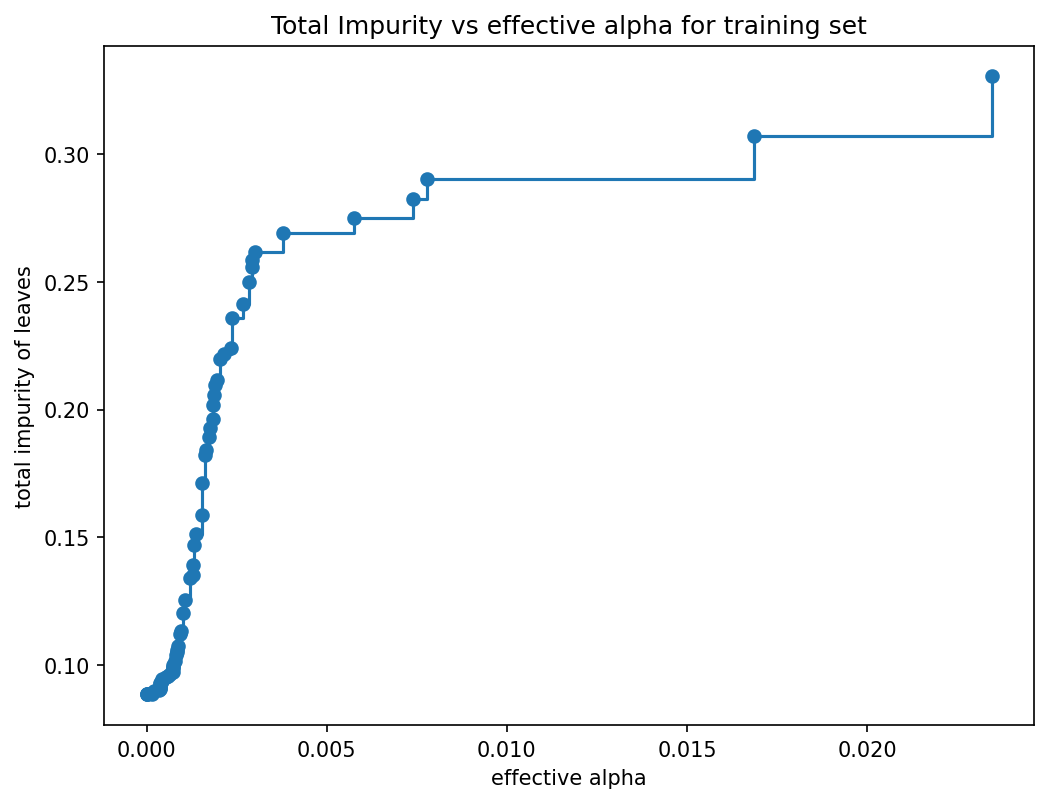

In [149]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.savefig('impurity_vs_alpha.pdf', bbox_inches='tight')

In [150]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.16880762217025946


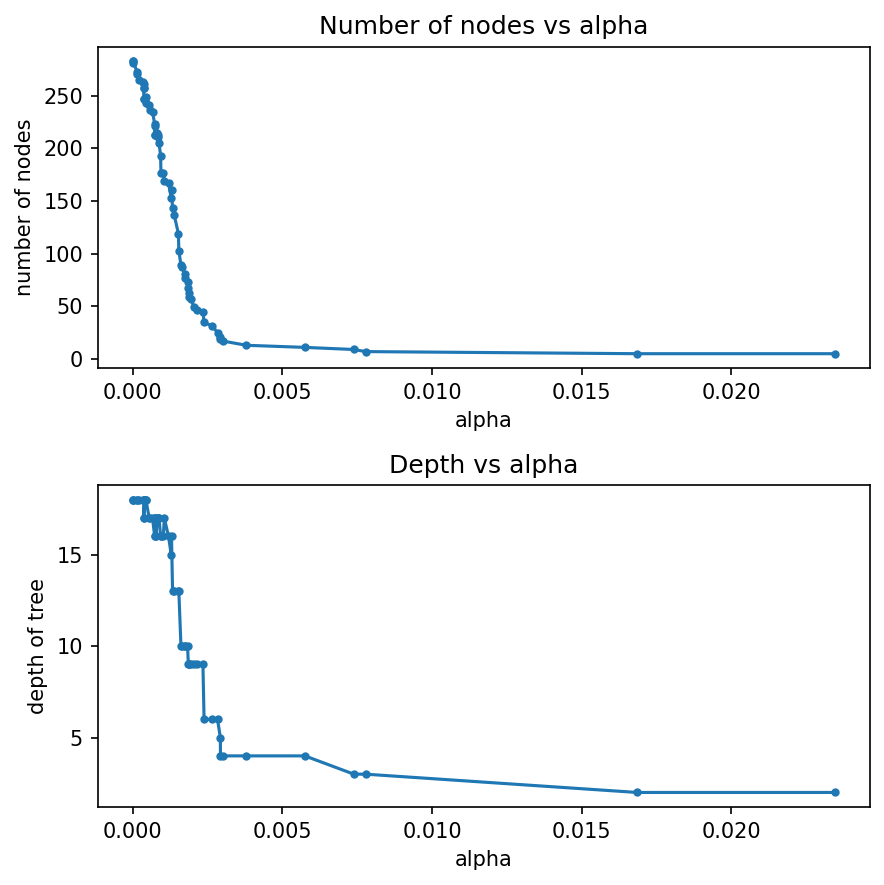

In [151]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(6,6), dpi=150)
ax[0].plot(ccp_alphas, node_counts, marker=".")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker=".")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.savefig('nodes_vs_alpha.pdf', bbox_inches='tight')

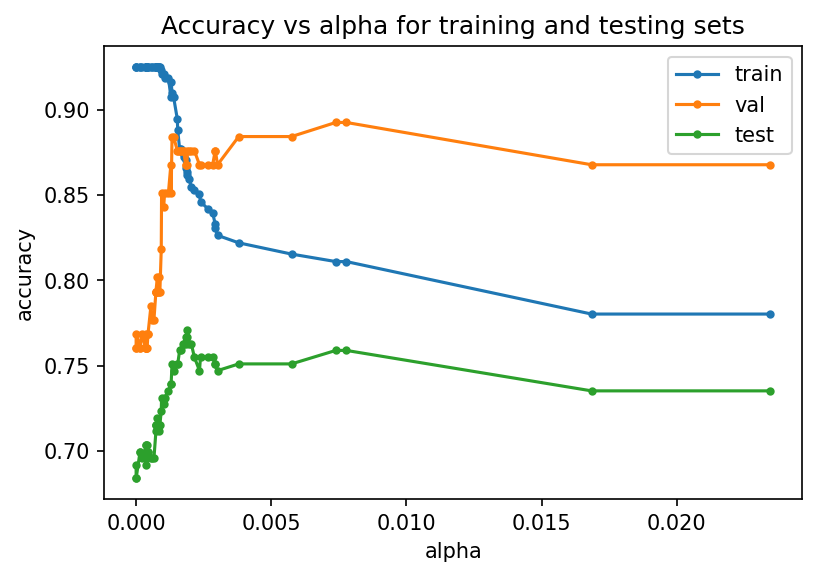

In [152]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker=".", label="train")
ax.plot(ccp_alphas, val_scores, marker=".", label="val")
ax.plot(ccp_alphas, test_scores, marker=".", label="test")
ax.legend()
plt.savefig('accuracy_vs_alpha.pdf', bbox_inches='tight')

In [153]:
best_tree_idx = np.argmax(val_scores)
print(
    "Number of nodes in the best tree is: {} with ccp_alpha: {}".format(
        clfs[best_tree_idx].tree_.node_count, ccp_alphas[best_tree_idx]
    )
)

Number of nodes in the best tree is: 9 with ccp_alpha: 0.00738705738705739


In [154]:
best_tree = clfs[best_tree_idx]
best_tree_alpha = ccp_alphas[best_tree_idx]

In [155]:
train_acc = best_tree.score(train_data[['Age', 'Shape', 'Margin', 'Density']], train_data['Severity'])
val_acc = best_tree.score(val_data[['Age', 'Shape', 'Margin', 'Density']], val_data['Severity'])
test_acc = best_tree.score(test_data[['Age', 'Shape', 'Margin', 'Density']], test_data['Severity'])

print(f"Train accuracy on best clf: {train_acc:.4f}")
print(f"Validation accuracy on best clf: {val_acc:.4f}")
print(f"Test accuracy on best clf: {test_acc:.4f}")

Train accuracy on best clf: 0.8110
Validation accuracy on best clf: 0.8926
Test accuracy on best clf: 0.7589


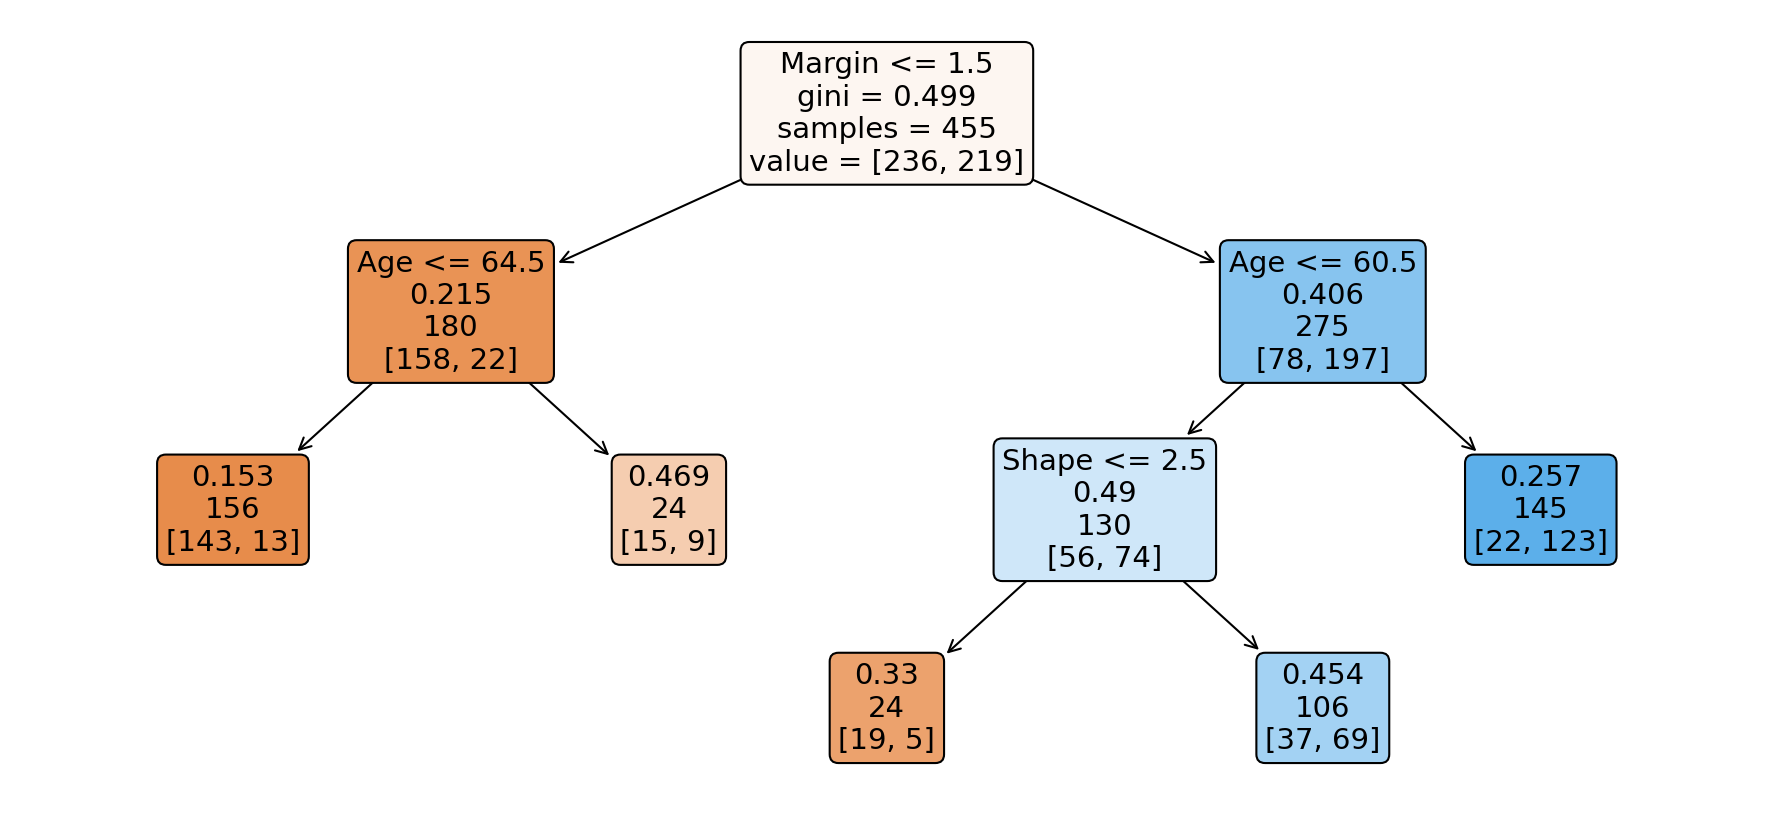

In [162]:
fig, ax = plt.subplots(figsize=(15,7), dpi=150)
ret = tree.plot_tree(best_tree, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True, max_depth=3) 
plt.savefig('tree_best_pruned.pdf', bbox_inches='tight')

In [169]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, oob_score=True)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.8099173553719008

In [174]:
def oob_score(estimator, X_test, y_test):
    return estimator.oob_score_

gs = GridSearchCV(clf, {'n_estimators': range(50,201,50), 'max_features': range(1,5), 'min_samples_split': range(2,6)}, scoring=oob_score)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(oob_score=True),
             param_grid={'max_features': range(1, 5),
                         'min_samples_split': range(2, 6),
                         'n_estimators': range(50, 201, 50)},
             scoring=<function oob_score at 0x12abe5b80>)

In [177]:
clf_best = gs.best_estimator_
print(f"Train accuracy: {accuracy_score(y_train, clf_best.predict(X_train)):.4f}")
print(f"Out of bag accuracy: {clf_best.oob_score_:.4f}")
print(f"Validation accuracy: {accuracy_score(y_val, clf_best.predict(X_val)):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, clf_best.predict(X_test)):.4f}")


Train accuracy: 0.9011
Out of bag accuracy: 0.7626
Validation accuracy: 0.8678
Test accuracy: 0.7668


In [178]:
gs.best_params_

{'max_features': 3, 'min_samples_split': 5, 'n_estimators': 200}

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

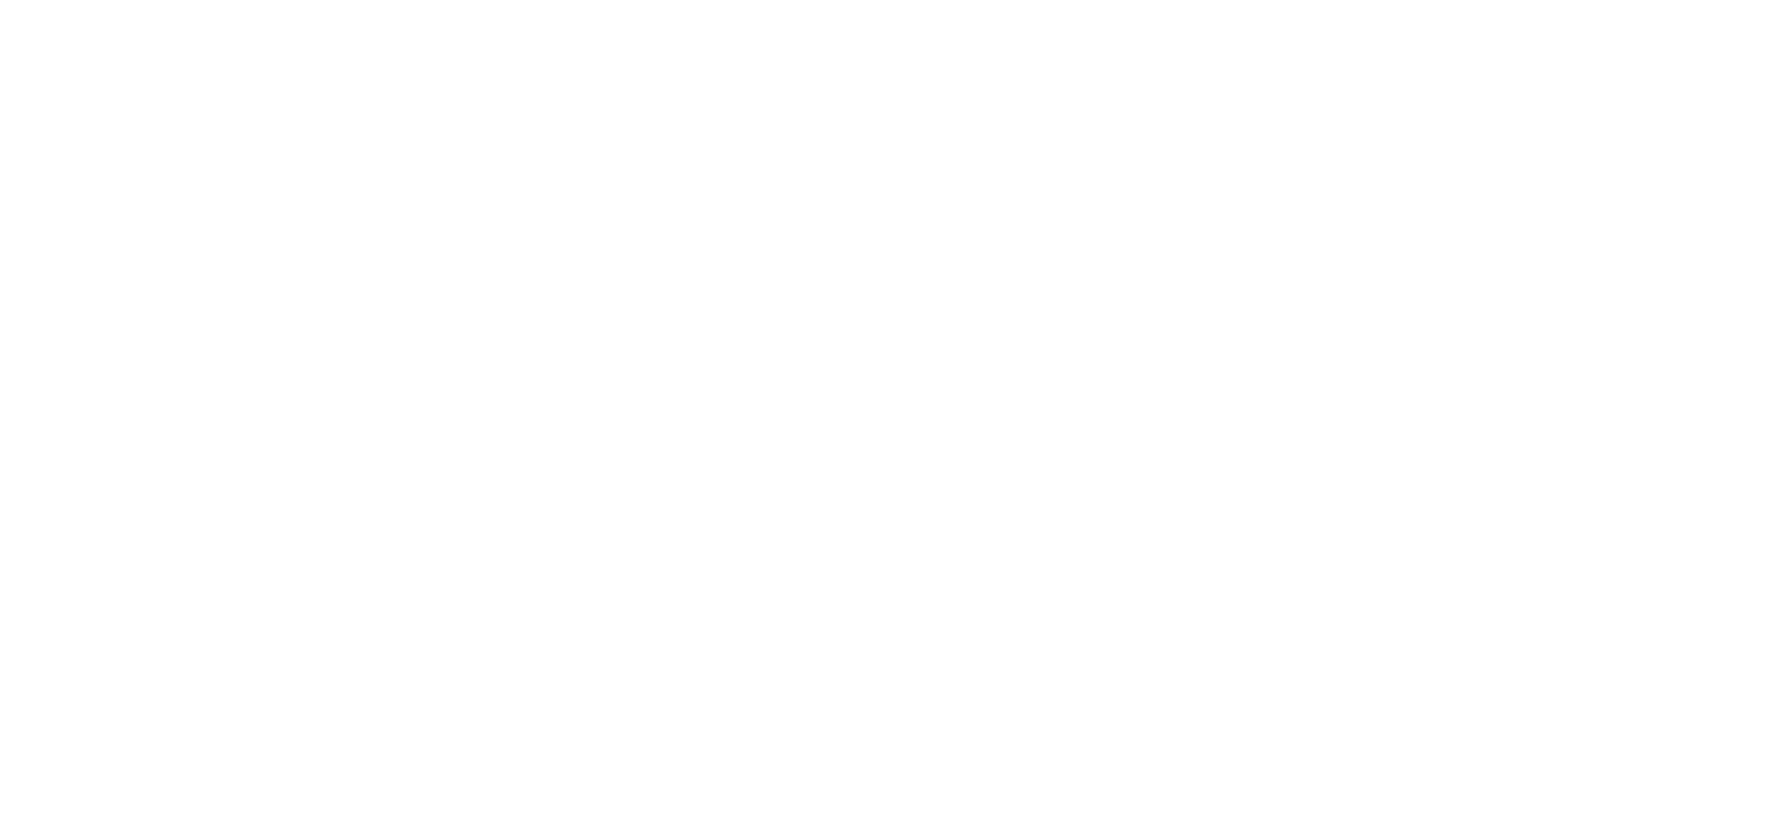